<img src="../style/img/vs265header.svg"/>

<h1 align="center">Lab 4 - Sparse, Distributed Representations <font color="red"> [SOLUTIONS] </font> </h1>

## Part 1 - Sparse Coding of Binary Patterns

In this problem you will implement Foldiak's model for learning features of binary data. Most of the code has been written for you, you only have to add the interesting parts - the dynamics, learning rules and statistics calculations.

We recommend that you read Foldiak's 1990 paper, <i>Forming Sparse Representations by Local Anti-Hebbian Learning</i>, before moving forward with this homework.

In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import utils.plotFunctions as pf
import utils.helperFunctions as hf

In [14]:
# Dataset generation
numDatapoints = 100 # Number of images in a batch
numInputs = 64 # Number of pixels in an image (must have integer sqrt)

# probabilityOn is used to determine, on average, what portion of the
# dataset has lines. It is also used to set the target output firing rate
# (num active / total num outputs) for the Foldiak model.
probabilityOn = 0.1

The `utils/helperFunctions.py` file contains a function called `genLines` that can be used to construct a binary line dataset. This is the same dataset as what is shown in Figure 2 of the Foldiak paper. The data contain a weighted random number of lines. The weighting is defined by the parameter probabilityOn. Check out the functin in utils/helperFunctions.py if you want to understand it better, or you can just run the code below and move on.

<IPython.core.display.Javascript object>


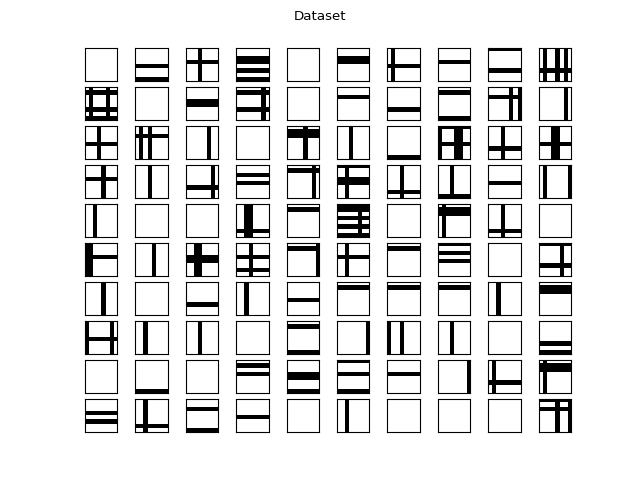

In [15]:
assert numInputs%np.sqrt(numInputs) == 0, (                                 
    "numInputs must have an integer square root") 

dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
pf.plotDataTiled(dataset, title="Dataset");

### 1.1 PCA

Our goal is to build a model that can learn the structure of this data. We know (because we made the data) that the basic building blocks of the data are a set of 16 lines, which can be combined and thresholded to make any of the images we see in our sample dataset.

A common first pass when modeling data is to perform linear PCA on the data, as you did in lab 3. If the data is linearly separable and drawn from a Gaussian distribution, then we should be able to use Hebbian learning rules to separate the individual building blocks, or causes, that combine to form the images in the dataset.

For this part of the problem, simply run the code cell below.

In [16]:
# Sanger's rule parameters
eta = 0.05 # Learning rate for Hebbian learning
numTrials = 4000 # Number of Hebbian learning steps to take
numOutputs = 16 # Number of neurons in the network layer

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning

<IPython.core.display.Javascript object>


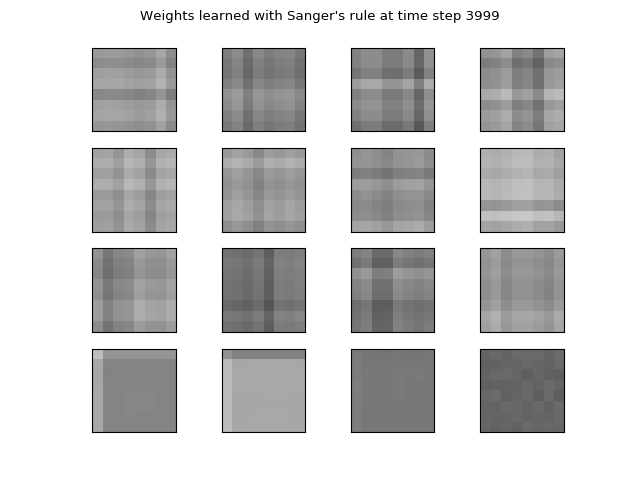

In [17]:
# Learn weights with Sanger's rule
weights = np.random.randn(numInputs, numOutputs)
prevFig = None
for trial in range(numTrials):
    dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
    learningRate = eta / numDatapoints # Batch normalization
    weights = hf.sangerLearn(dataset, weights, learningRate) 
    if trial % 1000 == 0:
        eta = eta * 0.8
    if trial % displayInterval == 0:
        prevFig = pf.plotDataTiled(weights, "Weights at time step "+str(trial), prevFig)

# Plot learned dictionary
prevFig = pf.plotDataTiled(weights, "Weights learned with Sanger's rule at time step "+str(trial), prevFig);

<b>YOUR ANSWER HERE:</b> What do you notice about the weights learned with Sanger's rule? Would you consider this an appropriate model of the generators of the data? Do you think a competitive network with a Winner-Take-All nonlinearity could model the data correctly? Why or why not?

<font color="red">Solution: </font>

Sanger's rule discovers the principal components of the dataset. PCA assumes the data comes from a linear generator of orthogonal components drawn from a Gaussian distribution and PCA models data in terms of pair-wise correlations. Our dataset, however, uses a non-linear generator and follows a distribution that is more similar to the 'x' distribution that was discussed in class. Our causes, the lines, are not orthogonal and have higher-order correlational structure. Thus, the output code produced using Sanger's rule is not too informative about what generated the dataset.

Given a good initial condition, it is possible that the Winner-Take-All (WTA) network could learn vectors that are close to some of the lines we used to generate the data. However, because the WTA network only allows one neuron to be active per input, it will fail to convey that the data is generated by combining multiple sources. 

Here, however, our data is best described in terms of a combination of multiple sources. To describe this data we want a model that allows multiple neurons to win and describes the data in terms of their corresponding weight vectors.

### 1.2 Foldiak's Sparse Coding Model

Next we will try to learn the data's structure using Foldiak's network. This network attemps to learn redundancies in the data while preserving information. The original purpose of the network was to attempt to explain a possible principle of computation that may be occuring in the visual processing areas of the brain.

First we need to set our learning rates. With some patience and tinkering, you see that the network can learn to extract the independent lines that create the dataset. The learning rate for the feedforward weights, $\beta$, needs to be slower than those for the lateral weights, $\alpha$, and thresholds, $\gamma$. Why is this?

<b>YOUR ANSWER HERE:</b> Why should $\alpha$ and $\gamma$ change faster than $\beta$?

<font color="red">Solution: </font>

The lateral weights and thresholds should change fastest because they influence the statistics of the network activations. The lateral weights encourage decorrelation and the thresholds set the sparsity. These values will be influenced heavily each time the forward weights are modified, so we want them to be able to adjust in between forward weight updates.

In [18]:
eta = 0.001 # Foldiak dynamics time constant
numTrials = 1000 # Number of Foldiak learning steps to take
numOutputs = 16 # Number of neurons in the network layer

# Foldiak learning rates
## Note that the lambda value in the foldiak paper (sigmoid steepness) is handled by the hf.sigmiod() function
alpha = 0.1 # Lateral weights learning rate
beta = 0.05 # Feedforward weights learning rate
gamma = 0.1 # Threshold learning rate
averageEta = 0.1 # Sliding average leak rate

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning

In [19]:
def foldiakSparsify(dataset, forwardWeights, lateralWeights, thresholds, numTrials):
    (numInputs, numDatapoints) = dataset.shape
    numOutputs = forwardWeights.shape[1]
    numEdgePixels = np.sqrt(numInputs)
    
    y = np.zeros((numOutputs, numDatapoints)) # Network output
    
    # Activations are computed by projecting the dataset onto the feedforward weights
    activations = forwardWeights.T @ dataset
    
    for trial in range(numTrials):
        # Run differential equation to allow network to settle to a solution
        # Hint: the 'thresholds' variable will need to be expanded. This can be done by using thresholds[:, None]
        # Hint: the hf.sigmoid() function is analagous to the f() function described in the foldiak y update equation
        dy = hf.sigmoid(activations + lateralWeights.T @ y - thresholds[:, None]) - y
        y += eta * dy
        
    output = np.zeros((numOutputs, numDatapoints))
    output[np.where(y>0.5)] = 1
    
    return output

def foldiakLearn(dataset, activity, forwardWeights, lateralWeights, thresholds, alpha, beta, gamma):
    numDataPoints = dataset.shape[1]
    
    # Compute activation statistics (avg across datapoints)
    avgActivity = np.mean(activity, axis=1)
    corrOutOut = activity @ activity.T / numDataPoints
    corrOutIn = dataset @ activity.T / numDataPoints
    
    # Update lateral weights (w in Foldiak paper)
    dw = -alpha * (corrOutOut - probabilityOn**2)
    lateralWeights += dw
    # Subtract Identity matrix so the units do not inhibit themselves
    lateralWeights -= np.diag(np.diag(lateralWeights))
    lateralWeights[np.where(lateralWeights>0)] = 0
    
    # Update feedforward weights (q in Foldiak paper)
    dq = beta * (corrOutIn - forwardWeights * avgActivity)
    forwardWeights += dq
    
    # Update thresholds (t in Foldiak paper)
    dthresh = gamma * (avgActivity - probabilityOn)
    thresholds += dthresh
    
    return (forwardWeights, lateralWeights, thresholds)

<IPython.core.display.Javascript object>


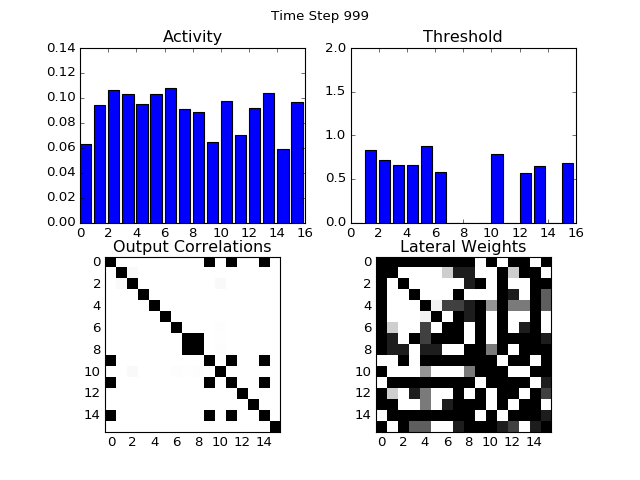

<IPython.core.display.Javascript object>


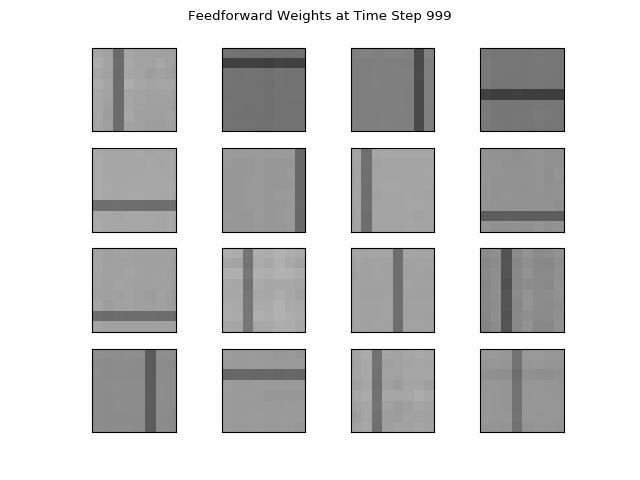

In [20]:
# Foldiak data structures
# Remember that numInputs, numOutputs, probabilityOn are all set above
forwardWeights = np.random.randn(numInputs, numOutputs)
lateralWeights = np.zeros((numOutputs, numOutputs))
thresholds = np.ones((numOutputs))
movingAverageActivity = probabilityOn
movingAverageCorrelation = probabilityOn**2

# Learn Foldiak model
prevFigs = [None, None]
for trial in range(numTrials):
    dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
    activity = foldiakSparsify(dataset, forwardWeights, lateralWeights, thresholds, numTrials)    
    (forwardWeights, lateralWeights, thresholds) = foldiakLearn(dataset, activity, forwardWeights, lateralWeights, thresholds, alpha, beta, gamma)
   
    # Store average correlation & activity for plotting
    activityMeans = np.mean(activity, axis=1)
    meanCenteredActivity = activity - activityMeans[:,None]
    movingAverageActivity = (1-averageEta) * movingAverageActivity + averageEta * activityMeans
    movingAverageCorrelation = (1-averageEta) * movingAverageCorrelation + averageEta * (meanCenteredActivity @ meanCenteredActivity.T / numDatapoints)
    
    if trial % displayInterval == 0:
        plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]
        prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
        prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]  
prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

<b>This next part is optional:</b> Now try using more and fewer than 16 output units, how does the network deal with these situations? You may need to modify your learning rates and `numTrials` to see a converged solution.

In [ ]:
numOutputs = 8 # Change numOutputs

# Foldiak data structures
# Remember that numInputs, numOutputs, probabilityOn are all set above
forwardWeights = np.random.randn(numInputs, numOutputs)
lateralWeights = np.zeros((numOutputs, numOutputs))
thresholds = np.ones((numOutputs))
movingAverageActivity = probabilityOn
movingAverageCorrelation = probabilityOn**2

# Learn Foldiak model
prevFigs = [None, None]
for trial in range(numTrials):
    dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
    activity = foldiakSparsify(dataset, forwardWeights, lateralWeights, thresholds, numTrials)    
    (forwardWeights, lateralWeights, thresholds) = foldiakLearn(dataset, activity, forwardWeights, lateralWeights, thresholds, alpha, beta, gamma)
   
    activityMeans = np.mean(activity, axis=1)
    meanCenteredActivity = activity - activityMeans[:,None]
    movingAverageActivity = (1-averageEta)*movingAverageActivity + averageEta * activityMeans
    movingAverageCorrelation = (1-averageEta)*movingAverageCorrelation + averageEta * (meanCenteredActivity @ meanCenteredActivity.T / numDatapoints)
    
    if trial % displayInterval == 0:
        plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]
        prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
        prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]  
prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

<font color="red">Solution: </font>

When fewer than 16 units are used, the model learns weight vectors that correspond to a random subset of the data points. When more units are used, the model takes much longer to converge to reasonable weights. You may find that some of the weights are repeated, where one version is a slightly less converged version of the other version. The model explicitly tries to prevent this from happening, although with only 16 generators it does not have a choice but to learn weights that are a superposition of the generators.